# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 103.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import optuna
import shutil
import json
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e6/train.csv"
    test_path = "/kaggle/input/playground-series-s5e6/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e6/sample_submission.csv"
    
    target = "Fertilizer Name"
    n_folds = 5
    seed = 42
    
    run_optuna = False
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

cat_cols = train.select_dtypes(include="object").columns.tolist()
cat_cols = [c for c in cat_cols if c != CFG.target]
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")

label_encoder = LabelEncoder()
train[CFG.target] = label_encoder.fit_transform(train[CFG.target])

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

In [5]:
mutual_info = mutual_info_classif(X, y, random_state=CFG.seed, discrete_features=True)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Moisture,0.003308
Phosphorous,0.002984
Nitrogen,0.002373
Crop Type,0.002088
Potassium,0.001367
Humidity,0.001015
Temparature,0.000966
Soil Type,0.000617


# Training base models

In [6]:
def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

In [7]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test, fit_args={}):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], y.nunique()))
        test_pred_probs = np.zeros((X_test.shape[0], y.nunique()))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            
            if fit_args:
                model.fit(X_train, y_train, **fit_args, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if fit_args:
                print(f"\n--- Fold {fold_idx + 1} - MAP@3: {score:.6f}\n\n")
            else:
                print(f"--- Fold {fold_idx + 1} - MAP@3: {score:.6f}")
                            
        overall_score = map3(y, oof_pred_probs)
            
        print(f"\n------ Overall MAP@3: {overall_score:.6f} | Average MAP@3: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        return oof_pred_probs, test_pred_probs, scores

    def tune(self, X, y):        
        scores = []        
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)

In [8]:
lgbm_params = {
    "device": "gpu",
    "boosting_type": "gbdt",
    "colsample_bytree": 0.4200885898620258,
    "learning_rate": 0.0664972405897673,
    "min_child_samples": 11,
    "min_child_weight": 0.01174009760234429,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 20,
    "random_state": 42,
    "reg_alpha": 4.145270698802584,
    "reg_lambda": 91.78710546495805,
    "subsample": 0.4170751765791902,
    "verbose": -1
}

lgbm_goss_params = {
    "device": "gpu",
    "boosting_type": "goss",
    "colsample_bytree": 0.39736332491996407,
    "learning_rate": 0.008033740989500222,
    "min_child_samples": 29,
    "min_child_weight": 0.6732469853333759,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 89,
    "random_state": 42,
    "reg_alpha": 15.595856670965969,
    "reg_lambda": 51.43625034648377,
    "subsample": 0.07846482736630467,
    "verbose": -1
}

xgb_params = {
    "device": "gpu",
    "colsample_bylevel": 0.8346068481666694,
    "colsample_bynode": 0.18131243335904124,
    "colsample_bytree": 0.6946413759525759,
    "early_stopping_rounds": 100,
    "enable_categorical": True,
    "gamma": 0.2342436435302897,
    "learning_rate": 0.08362033494121494,
    "max_depth": 23,
    "max_leaves": 36,
    "min_child_weight": 22,
    "n_estimators": 10000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 6.470456244170286,
    "reg_lambda": 34.83189979920049,
    "subsample": 0.816189053595861,
    "verbosity": 0
}

cb_params = {
    "iterations": 10000,
    "task_type": "GPU",
    "verbose": False
}

In [9]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

## LightGBM (gbdt)

In [10]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (gbdt)"], test_pred_probs["LightGBM (gbdt)"], scores["LightGBM (gbdt)"] = lgbm_trainer.fit_predict(X, y, X_test, fit_args)

Training LGBMClassifier



1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.91295
[2000]	valid_0's multi_logloss: 1.9088
[3000]	valid_0's multi_logloss: 1.90714
Early stopping, best iteration is:
[3756]	valid_0's multi_logloss: 1.90684

--- Fold 1 - MAP@3: 0.347600


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.91279
[2000]	valid_0's multi_logloss: 1.90828
[3000]	valid_0's multi_logloss: 1.90638
[4000]	valid_0's multi_logloss: 1.90576
Early stopping, best iteration is:
[4251]	valid_0's multi_logloss: 1.90564

--- Fold 2 - MAP@3: 0.348233


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.91231
[2000]	valid_0's multi_logloss: 1.9076
[3000]	valid_0's multi_logloss: 1.90562
[4000]	valid_0's multi_logloss: 1.90494
Early stopping, best iteration is:
[4264]	valid_0's multi_logloss: 1.90484

--- Fold 3 - MAP@3: 0.349820


Training until validation scores don't improve for 100 

## LightGBM (goss)

In [11]:
lgb_goss_model = LGBMClassifier(**lgbm_goss_params)
lgb_goss_trainer = Trainer(lgb_goss_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (goss)"], test_pred_probs["LightGBM (goss)"], scores["LightGBM (goss)"] = lgb_goss_trainer.fit_predict(X, y, X_test, fit_args)

Training LGBMClassifier

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.91875
[2000]	valid_0's multi_logloss: 1.91222
[3000]	valid_0's multi_logloss: 1.90902
[4000]	valid_0's multi_logloss: 1.90723
[5000]	valid_0's multi_logloss: 1.90639
Early stopping, best iteration is:
[5452]	valid_0's multi_logloss: 1.90616

--- Fold 1 - MAP@3: 0.347439


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.91882
[2000]	valid_0's multi_logloss: 1.91197
[3000]	valid_0's multi_logloss: 1.90845
[4000]	valid_0's multi_logloss: 1.90646
[5000]	valid_0's multi_logloss: 1.90539
[6000]	valid_0's multi_logloss: 1.90497
Early stopping, best iteration is:
[5968]	valid_0's multi_logloss: 1.90494

--- Fold 2 - MAP@3: 0.348656


Training until validation scores don't improve for 100 rounds
[1000]	valid_0's multi_logloss: 1.91843
[2000]	valid_0's multi_logloss: 1.91139
[3000]	valid_0's multi_logloss: 1.90791
[4000]	valid_0'

## XGBoost

In [12]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)

fit_args = {
    "verbose": 1000
}

oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test, fit_args)

Training XGBClassifier

[0]	validation_0-mlogloss:1.94542
[1000]	validation_0-mlogloss:1.91692
[2000]	validation_0-mlogloss:1.91364
[3000]	validation_0-mlogloss:1.91241
[4000]	validation_0-mlogloss:1.91171
[4768]	validation_0-mlogloss:1.91145

--- Fold 1 - MAP@3: 0.341217


[0]	validation_0-mlogloss:1.94543
[1000]	validation_0-mlogloss:1.91675
[2000]	validation_0-mlogloss:1.91323
[3000]	validation_0-mlogloss:1.91166
[4000]	validation_0-mlogloss:1.91083
[5000]	validation_0-mlogloss:1.91036
[6000]	validation_0-mlogloss:1.91006
[6464]	validation_0-mlogloss:1.90997

--- Fold 2 - MAP@3: 0.342176


[0]	validation_0-mlogloss:1.94533
[1000]	validation_0-mlogloss:1.91659
[2000]	validation_0-mlogloss:1.91308
[3000]	validation_0-mlogloss:1.91148
[4000]	validation_0-mlogloss:1.91065
[5000]	validation_0-mlogloss:1.91011
[5279]	validation_0-mlogloss:1.91005

--- Fold 3 - MAP@3: 0.342074


[0]	validation_0-mlogloss:1.94538
[1000]	validation_0-mlogloss:1.91715
[2000]	validation_0-mlogloss:1.91387
[300

## CatBoost

In [13]:
cb_model = CatBoostClassifier(**cb_params)
cb_trainer = Trainer(cb_model)

fit_args = {
    "verbose": 1000,
    "early_stopping_rounds": 100,
    "use_best_model": True,
    "cat_features": cat_cols
}

oof_pred_probs["CatBoost"], test_pred_probs["CatBoost"], scores["CatBoost"] = cb_trainer.fit_predict(X, y, X_test, fit_args)

Training CatBoostClassifier

Learning rate set to 0.073354
0:	learn: 1.9452752	test: 1.9453400	best: 1.9453400 (0)	total: 9.06s	remaining: 1d 1h 9m 47s
1000:	learn: 1.8975650	test: 1.9241188	best: 1.9241188 (1000)	total: 27.1s	remaining: 4m 4s
2000:	learn: 1.8718750	test: 1.9220102	best: 1.9219250 (1916)	total: 45.6s	remaining: 3m 2s
bestTest = 1.921925
bestIteration = 1916
Shrink model to first 1917 iterations.

--- Fold 1 - MAP@3: 0.325774


Learning rate set to 0.073354
0:	learn: 1.9452660	test: 1.9453027	best: 1.9453027 (0)	total: 20.8ms	remaining: 3m 28s
1000:	learn: 1.8984267	test: 1.9240179	best: 1.9240079 (997)	total: 18.1s	remaining: 2m 42s
2000:	learn: 1.8732052	test: 1.9217696	best: 1.9217642 (1970)	total: 36.5s	remaining: 2m 26s
bestTest = 1.9216375
bestIteration = 2263
Shrink model to first 2264 iterations.

--- Fold 2 - MAP@3: 0.327822


Learning rate set to 0.073354
0:	learn: 1.9452842	test: 1.9453210	best: 1.9453210 (0)	total: 20.2ms	remaining: 3m 21s
1000:	learn: 1.897

# Ensembling with LogisticRegression

In [14]:
X = pd.DataFrame(np.concatenate(list(oof_pred_probs.values()), axis=1))
X_test = pd.DataFrame(np.concatenate(list(test_pred_probs.values()), axis=1))

In [15]:
joblib.dump(X, "oof_pred_probs.pkl")
joblib.dump(X_test, "test_pred_probs.pkl")

['test_pred_probs.pkl']

In [16]:
def objective(trial):
    solver_penalty_options = [
        ('liblinear', 'l1'),
        ('liblinear', 'l2'),
        ('lbfgs', 'l2'),
        ('lbfgs', None)
    ]
    solver, penalty = trial.suggest_categorical('solver_penalty', solver_penalty_options)
    
    params = {
        'random_state': CFG.seed,
        'max_iter': 500,
        'C': trial.suggest_float('C', 0, 10),
        'tol': trial.suggest_float('tol', 1e-7, 1e-2),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'solver': solver,
        'penalty': penalty
    }
    
    model = LogisticRegression(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)


if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(objective, n_trials=250, n_jobs=-1)
    best_params = study.best_params
    
    solver, penalty = best_params['solver_penalty']
    lr_params = {
        'random_state': CFG.seed,
        'max_iter': 500,
        'solver': solver,
        'penalty': penalty,
        'fit_intercept': best_params['fit_intercept'],
        'class_weight': best_params['class_weight'],
        'C': best_params['C'],
        'tol': best_params['tol']
    }
else:
    lr_params = {
        'random_state': CFG.seed,
        'max_iter': 500
    }

In [17]:
print(json.dumps(lr_params, indent=2))

{
  "random_state": 42,
  "max_iter": 500
}


In [18]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model)

_, lr_test_pred_probs, scores["LogisticRegression"] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - MAP@3: 0.348333
--- Fold 2 - MAP@3: 0.350369
--- Fold 3 - MAP@3: 0.351000
--- Fold 4 - MAP@3: 0.350274
--- Fold 5 - MAP@3: 0.350257

------ Overall MAP@3: 0.350047 | Average MAP@3: 0.350047 ± 0.000899


In [19]:
final_predictions = []
for i in np.argsort(lr_test_pred_probs)[:, -3:][:, ::-1]:
    prediction = label_encoder.inverse_transform(i)
    final_predictions.append(" ".join(prediction))

In [20]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = final_predictions
sub.to_csv(f"sub_logistic-regression_{np.mean(scores['LogisticRegression']):.6f}.csv", index=False)
sub.head()

,id,Fertilizer Name
0,750000,10-26-26 DAP 28-28
1,750001,17-17-17 20-20 10-26-26
2,750002,20-20 28-28 17-17-17
3,750003,14-35-14 10-26-26 DAP
4,750004,20-20 10-26-26 Urea


# Results

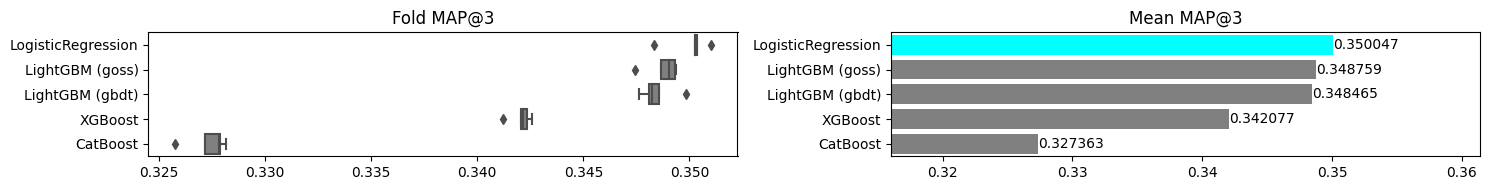

In [21]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "logistic" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [22]:
shutil.rmtree("catboost_info", ignore_errors=True)